In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

#For Document processing
#pip install python-docx 
from collections import Counter
import random
from docx import Document


#For Attention Matrix for 2 
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

'''
devNumber = torch.cuda.current_device()
devName = torch.cuda.get_device_name(devNumber)

print(f"Current device number is: {devNumber}")
print(f"GPU name is: {devName}")
'''



Using device: cuda


'\ndevNumber = torch.cuda.current_device()\ndevName = torch.cuda.get_device_name(devNumber)\n\nprint(f"Current device number is: {devNumber}")\nprint(f"GPU name is: {devName}")\n'

In [2]:
'''
Problem 1 (30pts)
In this homework, we focus on sequence-to-sequence modeling. Use the English to French Dataset provided. 
Developed a GRU-based encoder-decoder architecture for English to French Translation. 
Train the model on the entire dataset and evaluate it on the entire dataset. 
Report training loss, validation loss, and validation accuracy. 
Also, try some qualitative validation as well, asking the network to generate French translations for some English sentences.
'''

# Load dataset from .docx file
def load_english_french_pairs(docx_path):
    doc = Document(docx_path)
    text = "\n".join([p.text for p in doc.paragraphs])
    english_to_french = []
    
    for line in text.split("\n"):
        if '", "' in line:
            en, fr = line.split('", "')
            en = en.replace('("', '').strip()
            fr = fr.replace('")', '').strip()
            english_to_french.append((en, fr))
            
    return english_to_french

# Load dataset
dataset = load_english_french_pairs("Dataset - English to French.docx")

# Vocabulary builder
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
    
    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            index = len(self.word2index)
            self.word2index[word] = index
            self.index2word[index] = word

    def sentence_to_indices(self, sentence):
        return [self.word2index.get(word, self.word2index["<UNK>"]) for word in sentence.split()] + [self.word2index["<EOS>"]]

# Build vocabularies
english_vocab = Vocabulary()
french_vocab = Vocabulary()

for en, fr in dataset:
    english_vocab.add_sentence(en)
    french_vocab.add_sentence(fr)

# Custom dataset class
class TranslationDataset(Dataset):
    def __init__(self, pairs, english_vocab, french_vocab):
        self.pairs = pairs
        self.english_vocab = english_vocab
        self.french_vocab = french_vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        en_sentence, fr_sentence = self.pairs[idx]
        en_indices = self.english_vocab.sentence_to_indices(en_sentence)
        fr_indices = self.french_vocab.sentence_to_indices(fr_sentence)
        
        return torch.tensor(en_indices), torch.tensor(fr_indices)

# Collate function for padding
def collate_fn(batch):
    en_batch = [item[0] for item in batch]
    fr_batch = [item[1] for item in batch]

    en_batch = nn.utils.rnn.pad_sequence(en_batch, batch_first=True, padding_value=english_vocab.word2index["<PAD>"])
    fr_batch = nn.utils.rnn.pad_sequence(fr_batch, batch_first=True, padding_value=french_vocab.word2index["<PAD>"])

    return en_batch, fr_batch

# DataLoader
train_dataset = TranslationDataset(dataset, english_vocab, french_vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Encoder with LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.lstm(embedded)
        return output, hidden

    def initHidden(self, batch_size):
        return (torch.zeros(1, batch_size, hidden_size, device=device),
                torch.zeros(1, batch_size, hidden_size, device=device))

# Decoder with LSTM
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        embedded = self.embedding(x).unsqueeze(1)
        output, hidden = self.lstm(embedded, hidden)
        output = self.softmax(self.fc(output.squeeze(1)))
        return output, hidden

# Training epoch with teacher forcing
def train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device, teacher_forcing_ratio=0.5):
    encoder.train()
    decoder.train()
    total_loss = 0

    for input_tensor, target_tensor in train_loader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        batch_size = input_tensor.size(0)
        target_length = target_tensor.size(1)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden

        loss = 0

        # Use teacher forcing or not
        use_teacher_forcing = random.random() < teacher_forcing_ratio

        if use_teacher_forcing:
            # Use the true target as the next input (teacher forcing)
            for t in range(target_length):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Output: [batch_size, vocab_size], Target: [batch_size]
                loss += criterion(output, target_tensor[:, t])

                decoder_input = target_tensor[:, t]  # Teacher forcing
        else:
            # Use the model's predictions as the next input
            for t in range(target_length):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Output: [batch_size, vocab_size], Target: [batch_size]
                loss += criterion(output, target_tensor[:, t])

                # Get the top prediction
                _, topi = output.topk(1)
                decoder_input = topi.squeeze().detach()

        # Normalize the loss by the sequence length
        loss = loss / target_length

        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate_and_show_examples(encoder, decoder, dataloader, criterion, n_examples):
    encoder.eval()
    decoder.eval()
   
    total_loss = 0
    correct_predictions = 0  
    printed_examples = 0
  
    with torch.no_grad():
        for i, (input_tensor, target_tensor) in enumerate(dataloader):
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)

            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = encoder_hidden
            loss = 0
            predicted_indices = [[] for _ in range(batch_size)]

            # Generate predictions
            for t in range(target_tensor.size(1)):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Get the top prediction
                _, topi = output.topk(1)

                for b in range(batch_size):
                    predicted_indices[b].append(topi[b].item())

                decoder_input = topi.squeeze().detach()

                # Stop decoding if all sentences produce EOS
                if all(decoder_input == french_vocab.word2index["<EOS>"]):
                    break
            # Calculate and print loss and accuracy for the evaluation
            total_loss += criterion(output, target_tensor[:, t]).item()
            if predicted_indices == target_tensor.tolist():
                correct_predictions += 1            
            
            # Print examples while keeping track of the number of examples printed
            for batch_idx in range(batch_size):
                if printed_examples >= n_examples:
                    break  # Stop once n_examples have been printed

                predicted_words = [
                    french_vocab.index2word[idx]
                    for idx in predicted_indices[batch_idx]
                    if idx not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                target_words = [
                    french_vocab.index2word[idx.item()]
                    for idx in target_tensor[batch_idx]
                    if idx.item() not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                input_sentence = " ".join(
                    [english_vocab.index2word[idx.item()] 
                     for idx in input_tensor[batch_idx] 
                     if idx.item() not in [english_vocab.word2index["<PAD>"], english_vocab.word2index["<EOS>"]]]
                )          
                predicted_sentence = " ".join(predicted_words)
                target_sentence = " ".join(target_words)

                print(f"Input: {input_sentence}")
                print(f"Target: {target_sentence}")
                print(f"Predicted: {predicted_sentence}")
                print("-" * 30)
                printed_examples += 1  # Increment the counter

    # Calculate and display overall validation loss and accuracy
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader)
    print(f'Evaluation Loss: {average_loss:.4f}, Accuracy: {100*accuracy:.2f}%')

# Model parameters
embedding_size = 256
hidden_size = 512

input_size = len(english_vocab.word2index)
output_size = len(french_vocab.word2index)

encoder = Encoder(input_size, embedding_size, hidden_size).to(device)
decoder = Decoder(hidden_size, output_size, embedding_size).to(device)

# Optimizers and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.NLLLoss()

num_epochs = 50 
for epoch in range(num_epochs):
    loss = train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device)    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# Evaluate with examples
n_examples = 10
evaluate_and_show_examples(encoder, decoder, train_loader, criterion, n_examples)


Epoch 10, Loss: 2.3311
Epoch 20, Loss: 1.4117
Epoch 30, Loss: 0.5102
Epoch 40, Loss: 0.0908
Epoch 50, Loss: 0.0410
Input: They study French grammar
Target: Ils étudient la grammaire française,
Predicted: Ils étudient la grammaire française,
------------------------------
Input: We play music at the concert
Target: Nous jouons de la musique au concert,
Predicted: Nous jouons de la musique au concert,
------------------------------
Input: The movie starts at 7 PM
Target: Le film commence à 19 heures,
Predicted: Le film commence à 19 heures,
------------------------------
Input: He fixes the car
Target: Il répare la voiture,
Predicted: Il répare la voiture,
------------------------------
Input: We dance at the wedding
Target: Nous dansons au mariage,
Predicted: Nous dansons au mariage,
------------------------------
Input: They are students
Target: Ils sont étudiants,
Predicted: Ils sont étudiants,
------------------------------
Input: The book is on the table
Target: Le livre est sur la 

Epoch 10, Loss: 2.0216
Epoch 20, Loss: 0.2730
Epoch 30, Loss: 0.0377
Epoch 40, Loss: 0.0138
Epoch 50, Loss: 0.0084
Input: They read books at the library
Target: Ils lisent des livres à la bibliothèque,
Predicted: Ils lisent des livres à la bibliothèque,
------------------------------


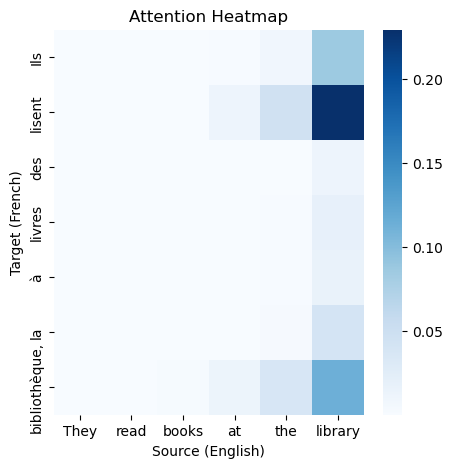

Input: We learn something new every day
Target: Nous apprenons quelque chose de nouveau chaque jour,
Predicted: Nous apprenons quelque chose de nouveau chaque jour,
------------------------------


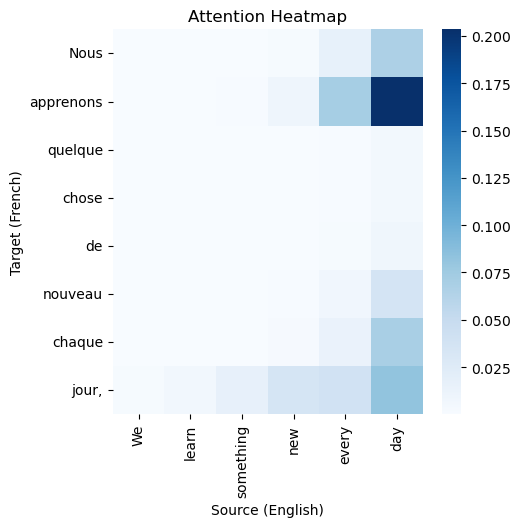

Input: They are students
Target: Ils sont étudiants,
Predicted: Ils sont étudiants,
------------------------------


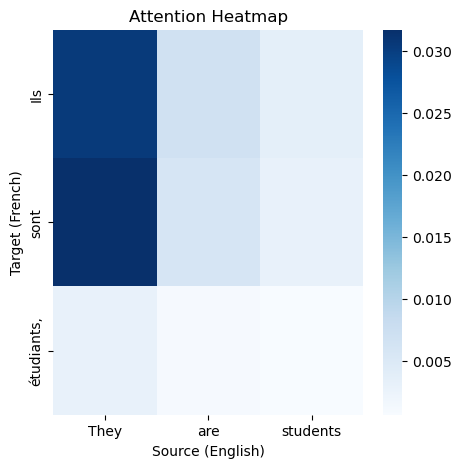

Input: You are tired
Target: Tu es fatigué,
Predicted: Tu es fatigué,
------------------------------


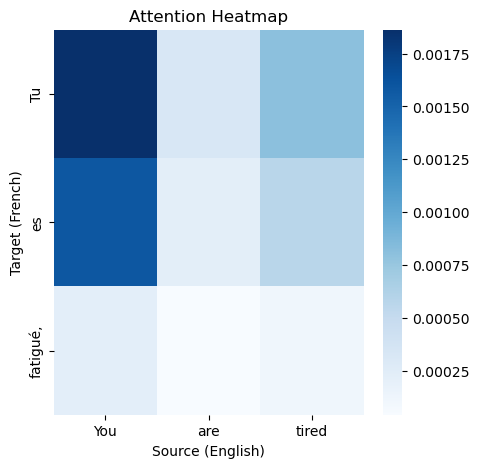

Input: The birds chirp in the morning
Target: Les oiseaux gazouillent le matin,
Predicted: Les oiseaux gazouillent le matin,
------------------------------


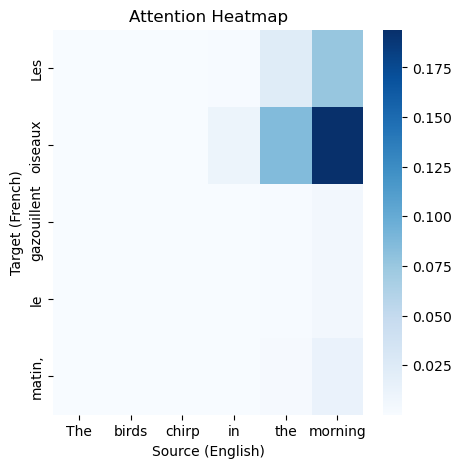

Input: We dance at the wedding
Target: Nous dansons au mariage,
Predicted: Nous dansons au mariage,
------------------------------


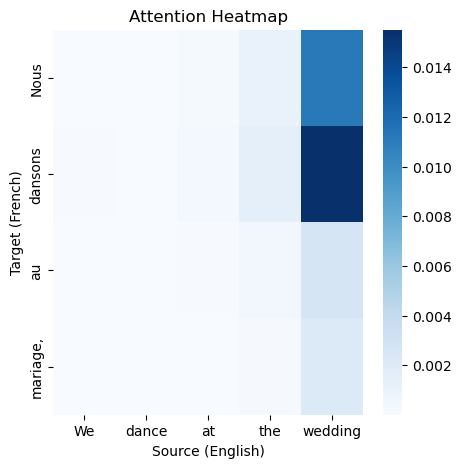

Input: The moon shines brightly
Target: La lune brille intensément,
Predicted: La lune brille intensément,
------------------------------


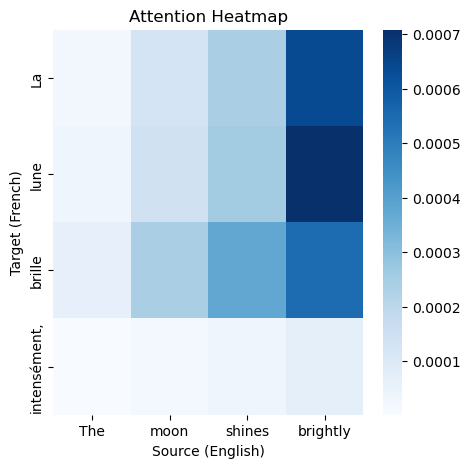

Input: She is happy
Target: Elle est heureuse,
Predicted: Elle est heureuse,
------------------------------


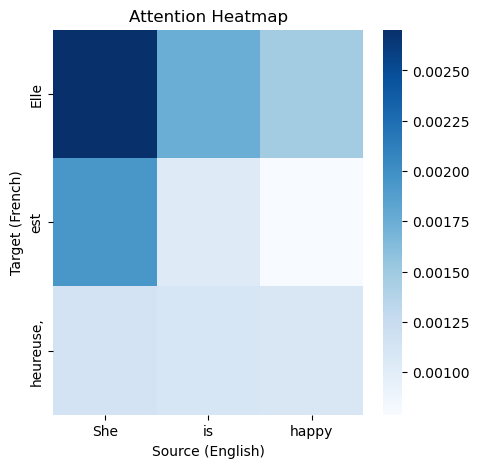

Input: The soup smells delicious
Target: La soupe sent délicieusement bon,
Predicted: La soupe sent délicieusement bon,
------------------------------


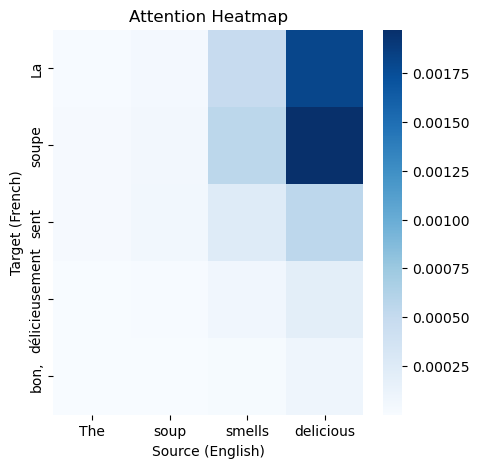

Input: We play music at the concert
Target: Nous jouons de la musique au concert,
Predicted: Nous jouons de la musique au concert,
------------------------------


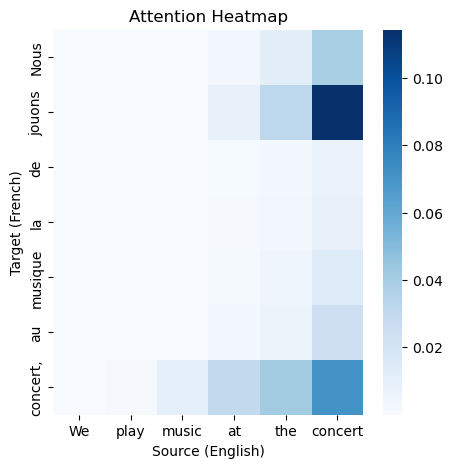

Evaluation Loss: 0.0023, Accuracy: 100.00%


In [3]:
'''Problem 2 (30pts)
Repeat problem 1, this time extend the network with attention. Train the model on the entire dataset and evaluate it on the entire dataset. 
Report training loss, validation loss, and validation accuracy. Also, try some qualitative validation as well, 
asking the network to generate French translations for some English sentences. Also, compare the results against problem 1.
'''
# Attention Layer
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch_size, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]

        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)

        # Repeat hidden state across the sequence length
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)

        # Concatenate hidden state with encoder outputs
        combined = torch.cat((hidden, encoder_outputs), dim=2)

        # Calculate attention scores
        energy = torch.tanh(self.attn(combined))
        attention = self.v(energy).squeeze(2)  # [batch_size, seq_len]

        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention, dim=1)

        # Weighted sum of encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        context = context.squeeze(1)

        return context, attention_weights

# Updated Decoder with Attention
class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size):
        super(AttentionDecoder, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size + hidden_size, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, encoder_outputs):
        embedded = self.embedding(x).unsqueeze(1)  # [batch_size, 1, embedding_size]

        # Apply attention
        context, attn_weights = self.attention(hidden[0][-1], encoder_outputs)
        
        # Combine context and embedding
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)

        # Pass through LSTM
        output, hidden = self.lstm(rnn_input, hidden)

        # Output layer
        output = self.fc(torch.cat((output.squeeze(1), context), dim=1))
        output = self.softmax(output)

        return output, hidden, attn_weights

# Training epoch with attention
def train_epoch_with_attention(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device, teacher_forcing_ratio=0.5):
    encoder.train()
    decoder.train()
    total_loss = 0

    for input_tensor, target_tensor in train_loader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        batch_size = input_tensor.size(0)
        target_length = target_tensor.size(1)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden

        loss = 0

        use_teacher_forcing = random.random() < teacher_forcing_ratio

        if use_teacher_forcing:
            for t in range(target_length):
                output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(output, target_tensor[:, t])
                decoder_input = target_tensor[:, t]
        else:
            for t in range(target_length):
                output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(output, target_tensor[:, t])
                _, topi = output.topk(1)
                decoder_input = topi.squeeze().detach()

        loss = loss / target_length
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Evaluation with attention
def evaluate_and_show_examples_with_attention(encoder, decoder, dataloader, criterion, n_examples):
    encoder.eval()
    decoder.eval()

    total_loss = 0
    printed_examples = 0
    correct_predictions = 0
    
    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)
            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = encoder_hidden

            predicted_indices = [[] for _ in range(batch_size)]
            attention_matrices = [[] for _ in range(batch_size)]

            # Loop through the target sequence
            for t in range(target_tensor.size(1)):
                output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
                _, topi = output.topk(1)

                for b in range(batch_size):
                    predicted_indices[b].append(topi[b].item())
                    attention_matrices[b].append(attn_weights[b].cpu().numpy())

                decoder_input = topi.squeeze().detach()
                
            # Calculate and print loss and accuracy for the evaluation
            total_loss += criterion(output, target_tensor[:, t]).item()
            if predicted_indices == target_tensor.tolist():
                correct_predictions += 1 
            # Print and visualize examples
            for batch_idx in range(batch_size):
                if printed_examples >= n_examples:
                    break

                # Convert predicted indices to words
                predicted_words = [
                    french_vocab.index2word[idx]
                    for idx in predicted_indices[batch_idx]
                    if idx not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                target_words = [
                    french_vocab.index2word[idx.item()]
                    for idx in target_tensor[batch_idx]
                    if idx.item() not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                input_words = [
                    english_vocab.index2word[idx.item()]
                    for idx in input_tensor[batch_idx]
                    if idx.item() not in [english_vocab.word2index["<PAD>"], english_vocab.word2index["<EOS>"]]
                ]

                predicted_sentence = " ".join(predicted_words)
                target_sentence = " ".join(target_words)
                input_sentence = " ".join(input_words)

                print(f"Input: {input_sentence}")
                print(f"Target: {target_sentence}")
                print(f"Predicted: {predicted_sentence}")
                print("-" * 30)
                # Display attention matrix
                attention_matrix = np.array(attention_matrices[batch_idx])
                attention_matrix = attention_matrix[:len(predicted_words), :len(input_words)]
                visualize_attention(input_words, predicted_words, attention_matrix)     
                printed_examples += 1
        #Calculate and display overall validation loss and accuracy
        average_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / len(dataloader)
        print(f'Evaluation Loss: {average_loss:.4f}, Accuracy: {100*accuracy:.2f}%')
                   
# Function to visualize attention
def visualize_attention(input_sentence, target_sentence, attention_matrix):
    fig = plt.subplots(figsize=(5, 5))
    sns.heatmap(attention_matrix, cmap='Blues', xticklabels=input_sentence, yticklabels=target_sentence)
    plt.xlabel('Source (English)')
    plt.ylabel('Target (French)')
    plt.title('Attention Heatmap')
    plt.show()
    
# Model parameters
embedding_size = 256
hidden_size = 512

input_size = len(english_vocab.word2index)
output_size = len(french_vocab.word2index)

# Initialize encoder and attention decoder
encoder = Encoder(input_size, embedding_size, hidden_size).to(device)
attention_decoder = AttentionDecoder(hidden_size, output_size, embedding_size).to(device)

# Optimizers and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(attention_decoder.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    loss = train_epoch_with_attention(encoder, attention_decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

# Evaluate with examples
n_examples = 10
evaluate_and_show_examples_with_attention(encoder, attention_decoder, train_loader, criterion, n_examples)

In [4]:
'''Problem 3 (40pts)
Repeat problems 1 and 2, this time try to translate from French to English. Train the model on the entire dataset and evaluate it on the entire dataset. 
Report training loss, validation loss, and validation accuracy. 
Also, try some qualitative validation as well, asking the network to generate French translations for some English sentences. 
Which one seems to be more effective, French-to-English or English-to-French?
'''

# Load dataset from .docx file
def load_english_french_pairs(docx_path):
    doc = Document(docx_path)
    text = "\n".join([p.text for p in doc.paragraphs])
    french_to_english = []
    for line in text.split("\n"):
        if '", "' in line:
            en, fr = line.split('", "')
            en = en.replace('("', '').strip()
            fr = fr.replace('")', '').strip()
            french_to_english.append((fr, en)) # Swap en, fr to fr, en for French to English       
    return french_to_english

# Load dataset
dataset = load_english_french_pairs("Dataset - English to French.docx")


# Vocabulary builder
class Vocabulary:
    def __init__(self):
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
    
    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            index = len(self.word2index)
            self.word2index[word] = index
            self.index2word[index] = word

    def sentence_to_indices(self, sentence):
        return [self.word2index.get(word, self.word2index["<UNK>"]) for word in sentence.split()] + [self.word2index["<EOS>"]]

# Build vocabularies
english_vocab = Vocabulary()
french_vocab = Vocabulary()

for en, fr in dataset:
    english_vocab.add_sentence(en)
    french_vocab.add_sentence(fr)

# Custom dataset class
class TranslationDataset(Dataset):
    def __init__(self, pairs, english_vocab, french_vocab):
        self.pairs = pairs
        self.english_vocab = english_vocab
        self.french_vocab = french_vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        en_sentence, fr_sentence = self.pairs[idx]
        en_indices = self.english_vocab.sentence_to_indices(en_sentence)
        fr_indices = self.french_vocab.sentence_to_indices(fr_sentence)
        
        return torch.tensor(en_indices), torch.tensor(fr_indices)

# Collate function for padding
def collate_fn(batch):
    en_batch = [item[0] for item in batch]
    fr_batch = [item[1] for item in batch]

    en_batch = nn.utils.rnn.pad_sequence(en_batch, batch_first=True, padding_value=english_vocab.word2index["<PAD>"])
    fr_batch = nn.utils.rnn.pad_sequence(fr_batch, batch_first=True, padding_value=french_vocab.word2index["<PAD>"])

    return en_batch, fr_batch

# DataLoader
train_dataset = TranslationDataset(dataset, english_vocab, french_vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


#No attention Seq2Seq model 
# Encoder with LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.lstm(embedded)
        return output, hidden

    def initHidden(self, batch_size):
        return (torch.zeros(1, batch_size, hidden_size, device=device),
                torch.zeros(1, batch_size, hidden_size, device=device))

# Decoder with LSTM
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        embedded = self.embedding(x).unsqueeze(1)
        output, hidden = self.lstm(embedded, hidden)
        output = self.softmax(self.fc(output.squeeze(1)))
        return output, hidden

# Training epoch with teacher forcing
def train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device, teacher_forcing_ratio=0.5):
    encoder.train()
    decoder.train()
    total_loss = 0

    for input_tensor, target_tensor in train_loader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        batch_size = input_tensor.size(0)
        target_length = target_tensor.size(1)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden

        loss = 0

        # Use teacher forcing or not
        use_teacher_forcing = random.random() < teacher_forcing_ratio

        if use_teacher_forcing:
            # Use the true target as the next input (teacher forcing)
            for t in range(target_length):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Output: [batch_size, vocab_size], Target: [batch_size]
                loss += criterion(output, target_tensor[:, t])

                decoder_input = target_tensor[:, t]  # Teacher forcing
        else:
            # Use the model's predictions as the next input
            for t in range(target_length):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Output: [batch_size, vocab_size], Target: [batch_size]
                loss += criterion(output, target_tensor[:, t])

                # Get the top prediction
                _, topi = output.topk(1)
                decoder_input = topi.squeeze().detach()

        # Normalize the loss by the sequence length
        loss = loss / target_length

        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate_and_show_examples(encoder, decoder, dataloader, criterion, n_examples):
    encoder.eval()
    decoder.eval()
   
    total_loss = 0
    correct_predictions = 0  
    printed_examples = 0
  
    with torch.no_grad():
        for i, (input_tensor, target_tensor) in enumerate(dataloader):
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)

            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = encoder_hidden
            loss = 0
            predicted_indices = [[] for _ in range(batch_size)]

            # Generate predictions
            for t in range(target_tensor.size(1)):
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)

                # Get the top prediction
                _, topi = output.topk(1)

                for b in range(batch_size):
                    predicted_indices[b].append(topi[b].item())

                decoder_input = topi.squeeze().detach()

                # Stop decoding if all sentences produce EOS
                if all(decoder_input == french_vocab.word2index["<EOS>"]):
                    break
            # Calculate and print loss and accuracy for the evaluation
            total_loss += criterion(output, target_tensor[:, t]).item()
            if predicted_indices == target_tensor.tolist():
                correct_predictions += 1            
            
            # Print examples while keeping track of the number of examples printed
            for batch_idx in range(batch_size):
                if printed_examples >= n_examples:
                    break  # Stop once n_examples have been printed

                predicted_words = [
                    french_vocab.index2word[idx]
                    for idx in predicted_indices[batch_idx]
                    if idx not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                target_words = [
                    french_vocab.index2word[idx.item()]
                    for idx in target_tensor[batch_idx]
                    if idx.item() not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                input_sentence = " ".join(
                    [english_vocab.index2word[idx.item()] 
                     for idx in input_tensor[batch_idx] 
                     if idx.item() not in [english_vocab.word2index["<PAD>"], english_vocab.word2index["<EOS>"]]]
                )          
                predicted_sentence = " ".join(predicted_words)
                target_sentence = " ".join(target_words)

                print(f"Input: {input_sentence}")
                print(f"Target: {target_sentence}")
                print(f"Predicted: {predicted_sentence}")
                print("-" * 30)
                printed_examples += 1  # Increment the counter

    # Calculate and display overall validation loss and accuracy
    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader)
    print(f'Evaluation Loss: {average_loss:.4f}, Accuracy: {100*accuracy:.2f}%')

# Model parameters
embedding_size = 256
hidden_size = 512

input_size = len(english_vocab.word2index)
output_size = len(french_vocab.word2index)

encoder = Encoder(input_size, embedding_size, hidden_size).to(device)
decoder = Decoder(hidden_size, output_size, embedding_size).to(device)

# Optimizers and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
criterion = nn.NLLLoss()

num_epochs = 50 
for epoch in range(num_epochs):
    loss = train_epoch(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device)    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# Evaluate with examples
n_examples = 10
evaluate_and_show_examples(encoder, decoder, train_loader, criterion, n_examples)



Epoch 10, Loss: 2.7187
Epoch 20, Loss: 1.7029
Epoch 30, Loss: 0.7954
Epoch 40, Loss: 0.2689
Epoch 50, Loss: 0.0901
Input: Nous regardons des films le vendredi,
Target: We watch movies on Fridays
Predicted: We watch movies on Fridays
------------------------------
Input: Nous jouons de la musique au concert,
Target: We play music at the concert
Predicted: We play music at the concert
------------------------------
Input: Nous voyageons en train,
Target: We travel by train
Predicted: We travel by train
------------------------------
Input: Elle chante une chanson,
Target: She sings a song
Predicted: She sings a song
------------------------------
Input: Elle attache ses lacets,
Target: She ties her shoelaces
Predicted: She ties her shoelaces
------------------------------
Input: Ils boivent du café le matin,
Target: They drink coffee in the morning
Predicted: They drink coffee in the morning
------------------------------
Input: Elle se promène le long de la plage,
Target: She walks alon

Epoch 10, Loss: 2.2893
Epoch 20, Loss: 0.5001
Epoch 30, Loss: 0.0394
Epoch 40, Loss: 0.0159
Epoch 50, Loss: 0.0111
Input: Elle rêve de voler,
Target: She dreams of flying
Predicted: She dreams of flying
------------------------------


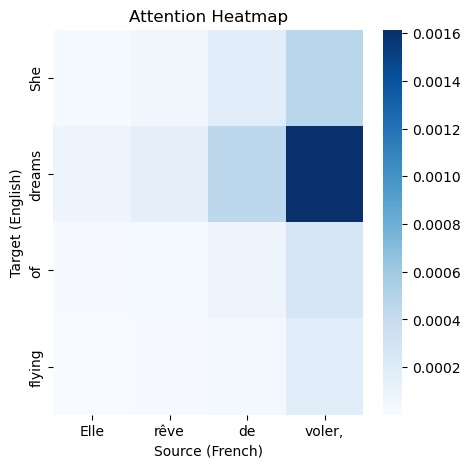

Input: La pluie tombe doucement,
Target: The rain falls gently
Predicted: The rain falls gently
------------------------------


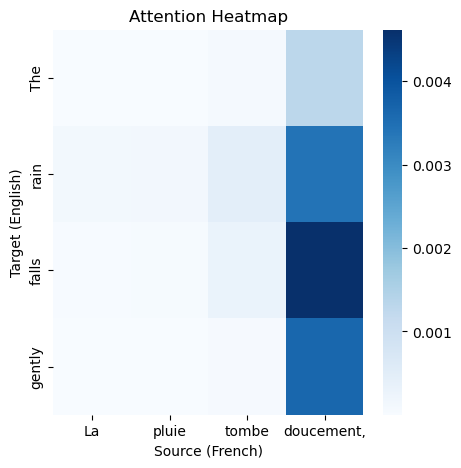

Input: Nous apprenons quelque chose de nouveau chaque jour,
Target: We learn something new every day
Predicted: We learn something new every day
------------------------------


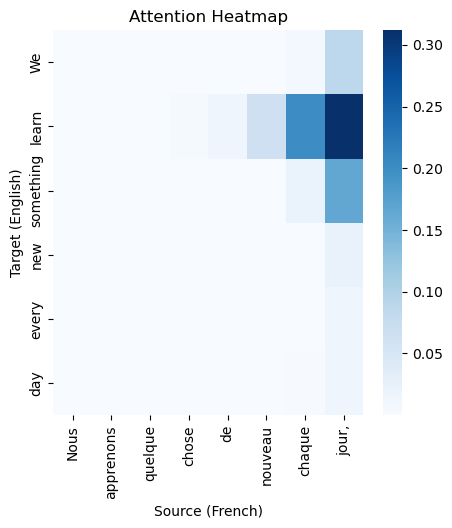

Input: Elle ferme la porte à clé,
Target: She locks the door
Predicted: She locks the door
------------------------------


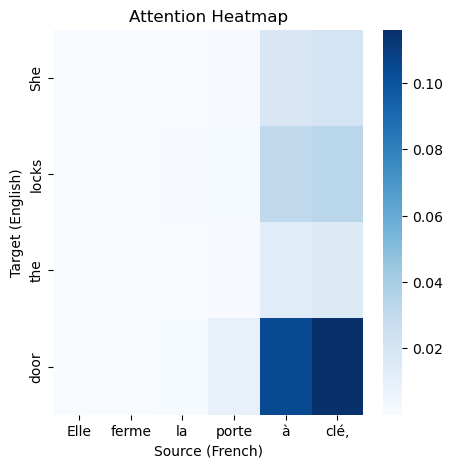

Input: Nous construisons un château de sable,
Target: We build a sandcastle
Predicted: We build a sandcastle
------------------------------


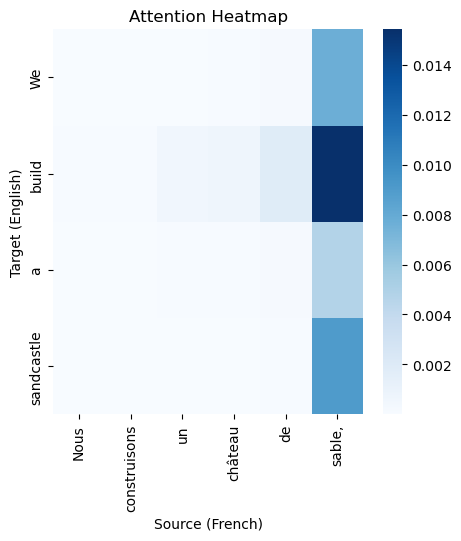

Input: Ils font du vélo,
Target: They ride bicycles
Predicted: They ride bicycles
------------------------------


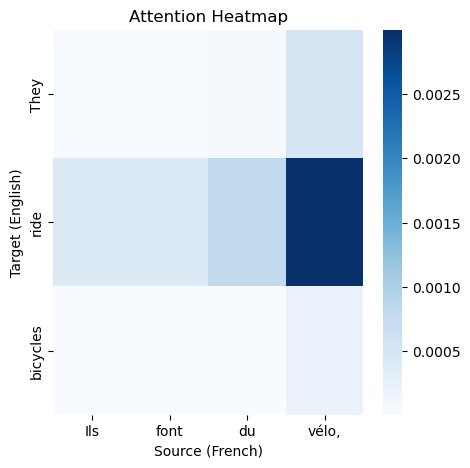

Input: Il cuisine le dîner pour sa famille,
Target: He cooks dinner for his family
Predicted: He cooks dinner for his family
------------------------------


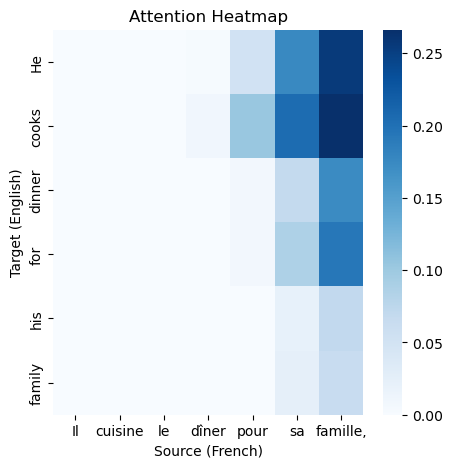

Input: Ils étudient la grammaire française,
Target: They study French grammar
Predicted: They study French grammar
------------------------------


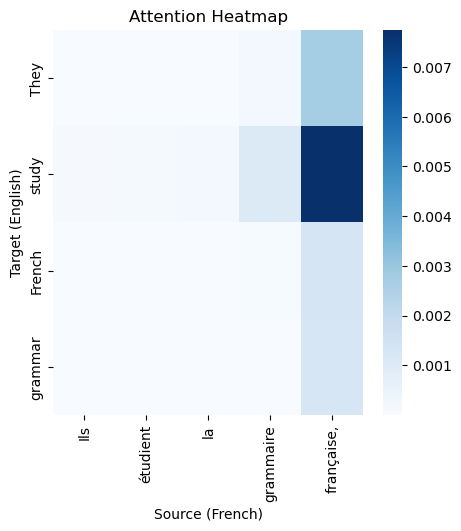

Input: La rivière coule calmement,
Target: The river flows calmly
Predicted: The river flows calmly
------------------------------


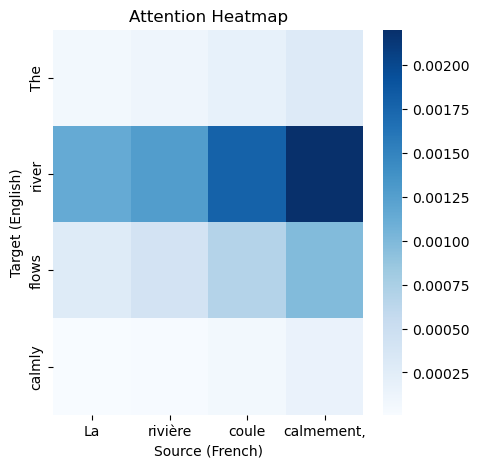

Input: Elle étudie les mathématiques à l'université,
Target: She studies mathematics at university
Predicted: She studies mathematics at university
------------------------------


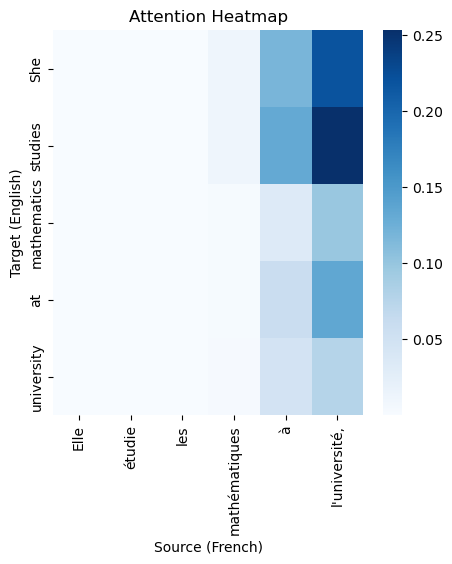

Evaluation Loss: 0.0043, Accuracy: 100.00%


In [6]:
#Seq2Seq model with attention

# Attention Layer
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch_size, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]

        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)

        # Repeat hidden state across the sequence length
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)

        # Concatenate hidden state with encoder outputs
        combined = torch.cat((hidden, encoder_outputs), dim=2)

        # Calculate attention scores
        energy = torch.tanh(self.attn(combined))
        attention = self.v(energy).squeeze(2)  # [batch_size, seq_len]

        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention, dim=1)

        # Weighted sum of encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        context = context.squeeze(1)

        return context, attention_weights

# Updated Decoder with Attention
class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size):
        super(AttentionDecoder, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size + hidden_size, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, encoder_outputs):
        embedded = self.embedding(x).unsqueeze(1)  # [batch_size, 1, embedding_size]

        # Apply attention
        context, attn_weights = self.attention(hidden[0][-1], encoder_outputs)
        
        # Combine context and embedding
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)

        # Pass through LSTM
        output, hidden = self.lstm(rnn_input, hidden)

        # Output layer
        output = self.fc(torch.cat((output.squeeze(1), context), dim=1))
        output = self.softmax(output)

        return output, hidden, attn_weights

# Training epoch with attention
def train_epoch_with_attention(encoder, decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device, teacher_forcing_ratio=0.5):
    encoder.train()
    decoder.train()
    total_loss = 0

    for input_tensor, target_tensor in train_loader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        batch_size = input_tensor.size(0)
        target_length = target_tensor.size(1)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_hidden = encoder.initHidden(batch_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden

        loss = 0

        use_teacher_forcing = random.random() < teacher_forcing_ratio

        if use_teacher_forcing:
            for t in range(target_length):
                output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(output, target_tensor[:, t])
                decoder_input = target_tensor[:, t]
        else:
            for t in range(target_length):
                output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(output, target_tensor[:, t])
                _, topi = output.topk(1)
                decoder_input = topi.squeeze().detach()

        loss = loss / target_length
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Evaluation with attention
def evaluate_and_show_examples_with_attention(encoder, decoder, dataloader, criterion, n_examples):
    encoder.eval()
    decoder.eval()

    total_loss = 0
    printed_examples = 0
    correct_predictions = 0
    
    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            batch_size = input_tensor.size(0)
            encoder_hidden = encoder.initHidden(batch_size)
            encoder_outputs, encoder_hidden = encoder(input_tensor)

            decoder_input = torch.full((batch_size,), french_vocab.word2index["<SOS>"], dtype=torch.long, device=device)
            decoder_hidden = encoder_hidden

            predicted_indices = [[] for _ in range(batch_size)]
            attention_matrices = [[] for _ in range(batch_size)]

            # Loop through the target sequence
            for t in range(target_tensor.size(1)):
                output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
                _, topi = output.topk(1)

                for b in range(batch_size):
                    predicted_indices[b].append(topi[b].item())
                    attention_matrices[b].append(attn_weights[b].cpu().numpy())

                decoder_input = topi.squeeze().detach()
                
            # Calculate and print loss and accuracy for the evaluation
            total_loss += criterion(output, target_tensor[:, t]).item()
            if predicted_indices == target_tensor.tolist():
                correct_predictions += 1 
            # Print and visualize examples
            for batch_idx in range(batch_size):
                if printed_examples >= n_examples:
                    break

                # Convert predicted indices to words
                predicted_words = [
                    french_vocab.index2word[idx]
                    for idx in predicted_indices[batch_idx]
                    if idx not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                target_words = [
                    french_vocab.index2word[idx.item()]
                    for idx in target_tensor[batch_idx]
                    if idx.item() not in [french_vocab.word2index["<PAD>"], french_vocab.word2index["<EOS>"]]
                ]
                input_words = [
                    english_vocab.index2word[idx.item()]
                    for idx in input_tensor[batch_idx]
                    if idx.item() not in [english_vocab.word2index["<PAD>"], english_vocab.word2index["<EOS>"]]
                ]

                predicted_sentence = " ".join(predicted_words)
                target_sentence = " ".join(target_words)
                input_sentence = " ".join(input_words)

                print(f"Input: {input_sentence}")
                print(f"Target: {target_sentence}")
                print(f"Predicted: {predicted_sentence}")
                print("-" * 30)
                # Display attention matrix
                attention_matrix = np.array(attention_matrices[batch_idx])
                attention_matrix = attention_matrix[:len(predicted_words), :len(input_words)]
                visualize_attention(input_words, predicted_words, attention_matrix)     
                printed_examples += 1
        #Calculate and display overall validation loss and accuracy
        average_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / len(dataloader)
        print(f'Evaluation Loss: {average_loss:.4f}, Accuracy: {100*accuracy:.2f}%')
                   
# Function to visualize attention
def visualize_attention(input_sentence, target_sentence, attention_matrix):
    fig = plt.subplots(figsize=(5, 5))
    sns.heatmap(attention_matrix, cmap='Blues', xticklabels=input_sentence, yticklabels=target_sentence)
    plt.xlabel('Source (French)')
    plt.ylabel('Target (English)')
    plt.title('Attention Heatmap')
    plt.show()
    
# Model parameters
embedding_size = 256
hidden_size = 512

input_size = len(english_vocab.word2index)
output_size = len(french_vocab.word2index)

# Initialize encoder and attention decoder
encoder = Encoder(input_size, embedding_size, hidden_size).to(device)
attention_decoder = AttentionDecoder(hidden_size, output_size, embedding_size).to(device)

# Optimizers and loss function
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(attention_decoder.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    loss = train_epoch_with_attention(encoder, attention_decoder, train_loader, criterion, encoder_optimizer, decoder_optimizer, device)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

# Evaluate with examples
n_examples = 10
evaluate_and_show_examples_with_attention(encoder, attention_decoder, train_loader, criterion, n_examples)